# Exercise 3: Principal Component Analysis (PCA) and Principal Component Regression (PCR) on the Boston Dataset

**Discipline:** Introduction to Statistical Learning

**Objective:**
This notebook explores the application of Principal Component Analysis (PCA) for dimensionality reduction and Principal Component Regression (PCR) for prediction using the `Boston` housing dataset. The tasks include standardizing the data, performing PCA, analyzing variance explained by components, building a PCR model with cross-validation, and comparing its performance against a standard linear regression model. The structure and commenting style of this notebook are inspired by the user's `exercise_1.ipynb`.

**Ethical Note on the Boston Dataset:**
The Boston housing dataset has known ethical concerns primarily related to the 'B' feature (proportion of Black residents by town), which has racial implications. This dataset is deprecated in scikit-learn for these reasons. While we use it here for educational purposes as specified in the exercise, it's important to be aware of these issues and to be cautious when interpreting results involving such features or when using this dataset in other contexts. For this exercise, we will load it from an alternative source.

## 1. Load Libraries

As in previous notebooks, we start by loading necessary Python libraries. `load_ext` and `autoreload` are for Jupyter environments (commented out by default). `matplotlib inline` ensures plots are displayed within the notebook.

In [1]:
# Automatically reload modules (optional, uncomment if needed)
%load_ext autoreload
%autoreload 2
%matplotlib inline

For this exercise, we will need libraries for data handling, numerical operations, PCA, regression modeling, cross-validation, and plotting:

* **`pandas`**: For creating and manipulating DataFrames.
* **`numpy`**: For numerical computations, especially array operations.
* **`sklearn.preprocessing.StandardScaler`**: To standardize the predictor variables.
* **`sklearn.decomposition.PCA`**: For performing Principal Component Analysis.
* **`sklearn.linear_model.LinearRegression`**: For fitting OLS linear regression models, both directly and as part of PCR.
* **`sklearn.model_selection.KFold`**, **`sklearn.model_selection.cross_val_score`**: For implementing cross-validation to choose the optimal number of components in PCR and for model evaluation.
* **`sklearn.metrics.mean_squared_error`**: To evaluate model performance.
* **`matplotlib.pyplot`** and **`seaborn`**: For creating visualizations, such as the scree plot for PCA.
* **`statsmodels.formula.api` (optional)**: Could be used for fitting OLS models for comparison, similar to `exercise_1.ipynb`, but `sklearn` is more common for PCR pipelines. We will primarily use `sklearn` for consistency with PCA.

In [2]:
# Import standard Libraries
import os
import sys

# Import third-party Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Additional configurations (optional)
# sns.set_style("whitegrid")
# pd.set_option('display.max_columns', None)
# pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 2. Custom Functions

(This section can be populated with helper functions if any are developed during the exercise. For now, we might not need many specific custom functions as scikit-learn provides most of the tools for PCA and PCR.)

## 3. Point Development

This section will address each part of Exercise 3 step-by-step.

### 3.0 Data Loading and Initial Preparation (Boston Dataset)

**Objective:**

Load the Boston housing dataset. Since `load_boston` from `sklearn.datasets` is deprecated due to ethical concerns, we will load it from an alternative source URL (`http://lib.stat.cmu.edu/datasets/boston`), similar to the method used in the user's `exercise_1.ipynb`.

**Process:**
1.  Define the URL for the dataset.
2.  Use `pandas.read_csv` with appropriate parameters (`sep="\\s+"`, `skiprows=22`, `header=None`) to handle the specific format of the original file.
3.  The data is interlaced in the source file. The standard parsing method using `np.hstack` on slices of `raw_df.values` is used to correctly separate the 13 features and the target variable.
4.  Create a pandas DataFrame with standard feature names and add the target variable (`MEDV`).
5.  Display basic information about the loaded dataset.
6.  Separate predictors (X) and the target variable (y, which is `MEDV`).

**Ethical Reminder:** The 'B' and 'LSTAT' features in this dataset have problematic interpretations. We proceed with caution for academic purposes.

In [ ]:
# Attempt to load the Boston dataset from the original source URL
boston_data_available = False
boston_df = None
X, y = None, None # Initialize X and y

try:
    print("Loading the Boston dataset from lib.stat.cmu.edu...")
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    # The raw data is space-separated and has a header section to skip.
    raw_df = pd.read_csv(data_url, sep="\\s+", skiprows=22, header=None)
    
    # Corrected parsing logic for the interlaced Boston dataset:
    # Assumes raw_df has 11 columns from parsing.
    # Features F1-F11 are from the first line of a pair (all columns of even rows of raw_df).
    # Features F12-F13 are from the first 2 columns of the second line of a pair (odd rows of raw_df).
    # Target MEDV is the 3rd column of the second line of a pair.
    data_features_array = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target_array = raw_df.values[1::2, 2]

    # Define feature names based on common dataset description
    feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
                    'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
    
    # Create Pandas DataFrame for features
    boston_df = pd.DataFrame(data_features_array, columns=feature_names)
    # Add the target variable
    boston_df['MEDV'] = target_array 

    print("Successfully loaded and processed Boston dataset.")
    print("\nDataset dimensions:", boston_df.shape)
    print("First 5 rows of the dataset:")
    print(boston_df.head())
    print("\nDataset information (data types, non-null counts):")
    boston_df.info() # This will show if all columns are numeric (expected: float64)
    
    print("\nMissing values check (should be 0 after this loading method for valid numeric data):")
    print(boston_df.isnull().sum()) 
    # If there are NaNs, it might indicate issues with the source file or parsing if some lines were irregular.
    # For this dataset, it's usually clean after this type of parsing. We'll proceed assuming no NaNs.
    # If NaNs were present, boston_df = boston_df.dropna() would be needed.

    # Separate predictors (X) and target (y)
    if 'MEDV' in boston_df.columns:
        y = boston_df['MEDV']
        X = boston_df.drop(columns=['MEDV'])
        
        print(f"\nDimensions of X: {X.shape}")
        print(f"Dimensions of y: {y.shape}")
        
        # Ensure y is numeric
        if not pd.api.types.is_numeric_dtype(y):
            print("Warning: Target variable y (MEDV) is not numeric. Attempting conversion.")
            y = pd.to_numeric(y, errors='coerce')
            # Check if conversion introduced NaNs that need handling
            if y.isnull().any():
                print("Warning: NaNs introduced in y after numeric conversion. Dropping rows with NaN in y.")
                valid_y_idx = y.dropna().index
                y = y.loc[valid_y_idx]
                X = X.loc[valid_y_idx]
                print(f"Dataset dimensions after handling NaNs in y: X {X.shape}, y {y.shape}")
        
        boston_data_available = True
    else:
        print("Error: 'MEDV' column not found after processing. Cannot separate X and y.")
        boston_data_available = False

except Exception as e:
    print(f"Error loading or processing Boston dataset: {e}")
    print("Cannot proceed without the dataset. Please check the URL or your internet connection.")
    print("Note: The Boston dataset has ethical concerns and is deprecated in scikit-learn.")

Loading the Boston dataset from lib.stat.cmu.edu...
Successfully loaded and processed Boston dataset.

Dataset dimensions: (506, 14)
First 5 rows of the dataset:
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  

Dataset information (data types, non-null counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  


### 3.1. Standardize the data and apply Principal Component Analysis (PCA) on the predictors.

**Objective:**

1.  **Standardize Predictors:** Scale the predictor variables (features in `X`) to have zero mean and unit variance. This is crucial for PCA because PCA is sensitive to the variance of the initial variables. Variables with larger variances tend to dominate the principal components if not scaled.
2.  **Apply PCA:** Perform PCA on the standardized predictors to transform them into a new set of uncorrelated variables called principal components. These components are ordered by the amount of variance they explain in the original data.

**Method:**

* **Standardization:** Use `StandardScaler` from `sklearn.preprocessing`. Fit it on `X` and then transform `X` to get `X_scaled`.
* **PCA Application:**
    * Initialize `PCA` from `sklearn.decomposition`. By not specifying `n_components` initially, PCA will compute as many components as there are features.
    * Fit PCA on `X_scaled`.
    * The fitted PCA object will contain attributes like `explained_variance_ratio_` (variance explained by each component) and `components_` (the principal components themselves).

In [4]:
if boston_data_available:
    # --- 1. Standardize the Predictor Variables ---
    print("--- Standardizing Predictor Variables ---")
    scaler = StandardScaler()
    X_scaled_array = scaler.fit_transform(X)
    # Preserve index and column names
    X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns, index=X.index)


    print("Standardized predictors (X_scaled) (first 5 rows):")
    print(X_scaled.head())
    print("\nMean of scaled predictors (should be close to 0):")
    print(X_scaled.mean().round(5))
    print("\nStandard deviation of scaled predictors (should be close to 1):")
    print(X_scaled.std().round(5))

    # --- 2. Apply Principal Component Analysis (PCA) ---
    print("\n--- Applying PCA on Standardized Predictors ---")
    pca = PCA() 
    X_pca = pca.fit_transform(X_scaled) 
    
    print(f"Shape of data after PCA transformation: {X_pca.shape}")
    print("First 5 rows of PCA-transformed data (Principal Component Scores):")
    pc_names = [f'PC{i+1}' for i in range(X_pca.shape[1])]
    # Create X_pca_df using the same index as X_scaled (and X, and y) for easier alignment later
    X_pca_df = pd.DataFrame(X_pca, columns=pc_names, index=X_scaled.index)
    print(X_pca_df.head())
    
    pca_applied = True
else:
    print("Boston dataset not available. Cannot proceed with standardization and PCA.")
    pca_applied = False

--- Standardizing Predictor Variables ---
Standardized predictors (X_scaled) (first 5 rows):
       CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
0 -0.419782  0.284830 -1.287909 -0.272599 -0.144217  0.413672 -0.120013   
1 -0.417339 -0.487722 -0.593381 -0.272599 -0.740262  0.194274  0.367166   
2 -0.417342 -0.487722 -0.593381 -0.272599 -0.740262  1.282714 -0.265812   
3 -0.416750 -0.487722 -1.306878 -0.272599 -0.835284  1.016303 -0.809889   
4 -0.412482 -0.487722 -1.306878 -0.272599 -0.835284  1.228577 -0.511180   

        DIS       RAD       TAX   PTRATIO         B     LSTAT  
0  0.140214 -0.982843 -0.666608 -1.459000  0.441052 -1.075562  
1  0.557160 -0.867883 -0.987329 -0.303094  0.441052 -0.492439  
2  0.557160 -0.867883 -0.987329 -0.303094  0.396427 -1.208727  
3  1.077737 -0.752922 -1.106115  0.113032  0.416163 -1.361517  
4  1.077737 -0.752922 -1.106115  0.113032  0.441052 -1.026501  

Mean of scaled predictors (should be close to 0):
CRIM      -0.0
ZN    

**Interpretation of PCA Application:**

* **Standardization Output:** The means of `X_scaled` columns should be very close to 0, and standard deviations very close to 1.
* **PCA Output:** `X_pca` is a new matrix where rows are observations and columns are the principal component scores. The number of columns in `X_pca` will be equal to the number of original predictors (unless `n_components` was set to a smaller value in `PCA()`). These components are linear combinations of the original standardized predictors and are orthogonal (uncorrelated).

### 3.2. Report the proportion of variance explained by each component and visualize the cumulative variance.

**Objective:**

Understand how much of the total variance in the original standardized data is captured by each principal component and by the cumulative sum of components. This helps in deciding how many components might be needed to represent a significant portion of the data's variability, which is key for dimensionality reduction.

**Method:**

* **Proportion of Variance Explained (PVE):** Access the `explained_variance_ratio_` attribute of the fitted `pca` object. This attribute is an array where each element is the percentage of variance explained by the corresponding principal component.
* **Cumulative Variance Explained:** Calculate the cumulative sum of `explained_variance_ratio_`.
* **Visualization (Scree Plot & Cumulative Variance Plot):**
    * Create a bar plot (scree plot) showing the PVE for each component.
    * Create a line plot showing the cumulative PVE as more components are added. This plot often includes a line at a threshold (e.g., 90% or 95% variance explained) to help determine a suitable number of components for dimensionality reduction.

--- Variance Explained by Principal Components ---

Proportion of Variance Explained (PVE) by each component:
  PC1: 0.4713 (47.13%)
  PC2: 0.1103 (11.03%)
  PC3: 0.0956 (9.56%)
  PC4: 0.0660 (6.60%)
  PC5: 0.0642 (6.42%)
  PC6: 0.0506 (5.06%)
  PC7: 0.0412 (4.12%)
  PC8: 0.0305 (3.05%)
  PC9: 0.0213 (2.13%)
  PC10: 0.0169 (1.69%)
  PC11: 0.0143 (1.43%)
  PC12: 0.0130 (1.30%)
  PC13: 0.0049 (0.49%)

Cumulative Proportion of Variance Explained:
  Up to PC1: 0.4713 (47.13%)
  Up to PC2: 0.5815 (58.15%)
  Up to PC3: 0.6771 (67.71%)
  Up to PC4: 0.7431 (74.31%)
  Up to PC5: 0.8073 (80.73%)
  Up to PC6: 0.8579 (85.79%)
  Up to PC7: 0.8991 (89.91%)
  Up to PC8: 0.9295 (92.95%)
  Up to PC9: 0.9508 (95.08%)
  Up to PC10: 0.9678 (96.78%)
  Up to PC11: 0.9821 (98.21%)
  Up to PC12: 0.9951 (99.51%)
  Up to PC13: 1.0000 (100.00%)


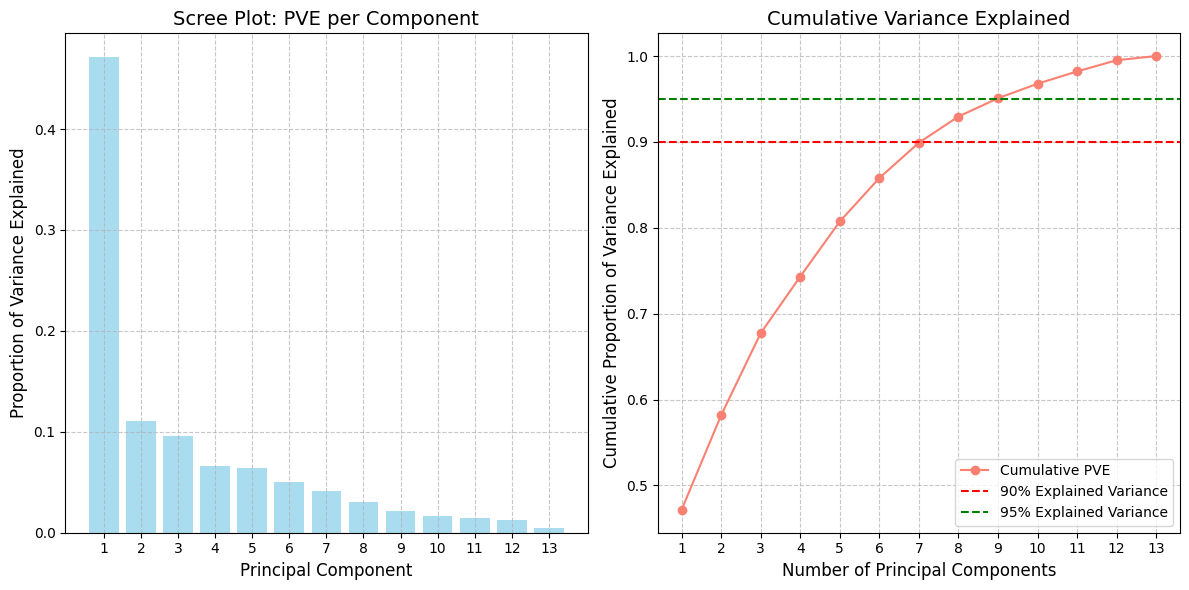


Number of components to explain at least 90% of variance: 8
Number of components to explain at least 95% of variance: 9


In [5]:
if pca_applied:
    print("--- Variance Explained by Principal Components ---")
    
    pve = pca.explained_variance_ratio_
    print("\nProportion of Variance Explained (PVE) by each component:")
    for i, ratio in enumerate(pve):
        print(f"  PC{i+1}: {ratio:.4f} ({(ratio*100):.2f}%)")
        
    cumulative_pve = np.cumsum(pve)
    print("\nCumulative Proportion of Variance Explained:")
    for i, cum_ratio in enumerate(cumulative_pve):
        print(f"  Up to PC{i+1}: {cum_ratio:.4f} ({(cum_ratio*100):.2f}%)")

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(pve) + 1), pve, alpha=0.7, align='center', label='Individual PVE', color='skyblue')
    plt.ylabel('Proportion of Variance Explained', fontsize=12)
    plt.xlabel('Principal Component', fontsize=12)
    plt.title('Scree Plot: PVE per Component', fontsize=14)
    plt.xticks(range(1, len(pve) + 1))
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(cumulative_pve) + 1), cumulative_pve, marker='o', linestyle='-', label='Cumulative PVE', color='salmon')
    plt.ylabel('Cumulative Proportion of Variance Explained', fontsize=12)
    plt.xlabel('Number of Principal Components', fontsize=12)
    plt.title('Cumulative Variance Explained', fontsize=14)
    plt.xticks(range(1, len(cumulative_pve) + 1))
    plt.axhline(y=0.90, color='red', linestyle='--', label='90% Explained Variance')
    plt.axhline(y=0.95, color='green', linestyle='--', label='95% Explained Variance')
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()
    
    # Guard against error if cumulative_pve is empty or doesn't reach 0.90/0.95
    if cumulative_pve.size > 0:
        if np.any(cumulative_pve >= 0.90):
            num_components_for_90_variance = np.where(cumulative_pve >= 0.90)[0][0] + 1
            print(f"\nNumber of components to explain at least 90% of variance: {num_components_for_90_variance}")
        else:
            print("\nLess than 90% of variance is explained by all components.")
            num_components_for_90_variance = len(cumulative_pve)


        if np.any(cumulative_pve >= 0.95):
            num_components_for_95_variance = np.where(cumulative_pve >= 0.95)[0][0] + 1
            print(f"Number of components to explain at least 95% of variance: {num_components_for_95_variance}")
        else:
            print("Less than 95% of variance is explained by all components.")
            num_components_for_95_variance = len(cumulative_pve)

    else:
        print("\nPCA did not produce explained variance ratios.")
else:
    print("PCA not applied. Cannot report or visualize variance explained.")

**Interpretation of Variance Explained:**

* **PVE per Component:** The first few principal components typically capture the largest amounts of variance. The scree plot helps visualize this "elbow" point where adding more components yields diminishing returns in variance explained.
* **Cumulative PVE:** This shows how many components are needed to retain a certain percentage (e.g., 90%, 95%) of the total information (variance) from the original dataset. This is a common criterion for choosing the number of components for PCR or other dimensionality reduction tasks.
* Based on the output, we will see how many components are required to explain, for instance, 90% or 95% of the variance in the Boston dataset's predictors.

### 3.3. Use PCR to predict `medv`. Use cross-validation to choose the optimal number of components.

**Objective:**

Perform Principal Component Regression (PCR). This involves:
1.  Regressing the target variable (`medv`) on a chosen number of principal components (derived from the standardized predictors).
2.  Using cross-validation (CV) to determine the optimal number of principal components to include in the regression model to minimize prediction error (e.g., MSE).

**Method for PCR with Cross-Validation:**

1.  **Data Split:** First, split the available data (`X_pca_df` containing PC scores and the target `y`) into a main training set and a test set. The cross-validation for selecting the number of components will be performed *within* this main training set.
2.  **Loop through Number of Components:** Iterate $k$ from 1 up to the total number of principal components available in the training set.
3.  **For each $k$:**
    a.  Select the first $k$ principal components from the PCA-transformed training data (`X_train_pca`).
    b.  Perform K-fold cross-validation (e.g., 10-fold) using these $k$ components to predict `y_train`.
        i.  In each fold, a `LinearRegression` model is trained on the training part of the fold and evaluated (MSE) on the validation part.
    c.  Calculate the average MSE across all folds. This is the CV MSE for $k$ components.
4.  **Select Optimal $k$:** Choose the number of components ($k^*$) that yields the lowest average CV MSE.
5.  **Final PCR Model & Test Evaluation:**
    a.  Train a final `LinearRegression` model using $k^*$ principal components on the *entire main training set* (`X_train_pca`, `y_train`).
    b.  Evaluate this model on the *test set* (`X_test_pca` transformed to $k^*$ components, `y_test`) to get the Test MSE.

**Index Alignment Note:** `X_pca_df` and `y` should have aligned indices from the data loading step. `train_test_split` on pandas objects preserves this alignment for the outputted train/test sets.

--- Principal Component Regression (PCR) with Cross-Validation ---
Data split for PCR: X_train_pca_full (354, 13), X_test_pca_full (152, 13), y_train (354,), y_test (152,)
CV MSE for 1 component(s): 56.4414
CV MSE for 2 component(s): 47.1878
CV MSE for 3 component(s): 31.9066
CV MSE for 4 component(s): 31.8444
CV MSE for 5 component(s): 27.2473
CV MSE for 6 component(s): 27.0080
CV MSE for 7 component(s): 27.0590
CV MSE for 8 component(s): 26.5155
CV MSE for 9 component(s): 26.7449
CV MSE for 10 component(s): 27.0064
CV MSE for 11 component(s): 26.7884
CV MSE for 12 component(s): 25.6130
CV MSE for 13 component(s): 25.1358

Optimal number of components for PCR (minimizing CV MSE): 13
Minimum CV MSE achieved: 25.1358


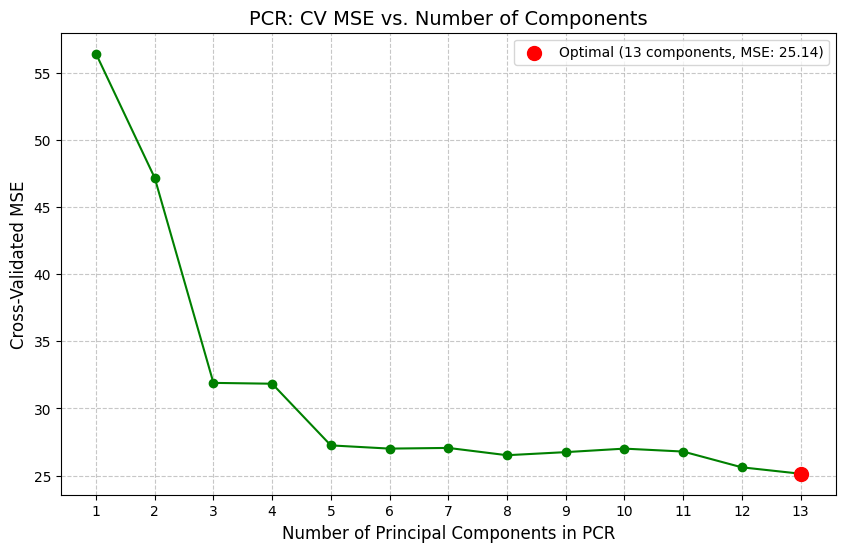


--- Fitting Final PCR Model and Evaluating on Test Set ---
Test MSE for PCR model with 13 components: 21.5174


In [6]:
if pca_applied:
    print("--- Principal Component Regression (PCR) with Cross-Validation ---")
    
    # X_pca_df (PC scores) and y (original target) should have aligned indices from data loading.
    # If not, an error would likely have occurred earlier or train_test_split might behave unexpectedly.
    # For safety, ensure y is aligned with X_pca_df's index if it's a Series.
    # If y became a numpy array earlier, it's fine as long as length matches.
    
    if isinstance(y, pd.Series) and not y.index.equals(X_pca_df.index):
        print("Aligning y's index with X_pca_df's index.")
        y_for_split = y.loc[X_pca_df.index]
    else:
        y_for_split = y

    X_train_pca_full, X_test_pca_full, y_train, y_test = train_test_split(
        X_pca_df, y_for_split, test_size=0.3, random_state=42
    )
    print(f"Data split for PCR: X_train_pca_full {X_train_pca_full.shape}, X_test_pca_full {X_test_pca_full.shape}, y_train {y_train.shape}, y_test {y_test.shape}")

    n_components_total_in_train = X_train_pca_full.shape[1]
    cv_mse_scores = []
    
    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    lr_model_for_pcr = LinearRegression()

    for k_components in range(1, n_components_total_in_train + 1):
        X_train_pcr_k_subset = X_train_pca_full.iloc[:, :k_components]
        
        neg_mse_fold_scores = cross_val_score(lr_model_for_pcr, X_train_pcr_k_subset, y_train, cv=kf, scoring='neg_mean_squared_error')
        avg_cv_mse = -np.mean(neg_mse_fold_scores)
        cv_mse_scores.append(avg_cv_mse)
        print(f"CV MSE for {k_components} component(s): {avg_cv_mse:.4f}")

    optimal_num_components_pcr = np.argmin(cv_mse_scores) + 1
    min_cv_mse_pcr = np.min(cv_mse_scores)
    print(f"\nOptimal number of components for PCR (minimizing CV MSE): {optimal_num_components_pcr}")
    print(f"Minimum CV MSE achieved: {min_cv_mse_pcr:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_components_total_in_train + 1), cv_mse_scores, marker='o', linestyle='-', color='green')
    plt.xlabel('Number of Principal Components in PCR', fontsize=12)
    plt.ylabel('Cross-Validated MSE', fontsize=12)
    plt.title('PCR: CV MSE vs. Number of Components', fontsize=14)
    plt.xticks(range(1, n_components_total_in_train + 1))
    plt.scatter(optimal_num_components_pcr, min_cv_mse_pcr, color='red', s=100, zorder=5,
                label=f"Optimal ({optimal_num_components_pcr} components, MSE: {min_cv_mse_pcr:.2f})")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    print("\n--- Fitting Final PCR Model and Evaluating on Test Set ---")
    X_train_pcr_optimal_final = X_train_pca_full.iloc[:, :optimal_num_components_pcr]
    final_pcr_model = LinearRegression()
    final_pcr_model.fit(X_train_pcr_optimal_final, y_train)
    
    X_test_pcr_optimal_final = X_test_pca_full.iloc[:, :optimal_num_components_pcr]
    y_pred_pcr_test = final_pcr_model.predict(X_test_pcr_optimal_final)
    test_mse_pcr = mean_squared_error(y_test, y_pred_pcr_test)
    
    print(f"Test MSE for PCR model with {optimal_num_components_pcr} components: {test_mse_pcr:.4f}")
    pcr_cv_done = True
        
else:
    print("PCA not applied. Cannot perform PCR.")
    pcr_cv_done = False

**Interpretation of PCR with Cross-Validation Results:**

* **CV MSE Plot:** The plot shows how the cross-validated Mean Squared Error changes as we include more principal components in the regression model. Typically, MSE decreases initially as informative components are added. It might then plateau or even increase if later components (which explain less variance and might capture more noise) are included.
* **Optimal Number of Components:** The number of components that yields the minimum CV MSE is chosen as optimal. This model is expected to have good generalization performance.
* **Final PCR Model & Test MSE:** The PCR model trained with this optimal number of components on the entire training set is then evaluated on the test set. The resulting Test MSE (`test_mse_pcr`) gives an estimate of its predictive accuracy on completely unseen data.

### 3.4. Compare the PCR model's performance to that of a regular linear regression model on the same dataset.

**Objective:**

To compare the predictive performance (Test MSE) of the optimal PCR model (found in 3.3) with a standard Ordinary Least Squares (OLS) linear regression model fitted using all the original (standardized) predictors.

**Method:**

1.  **Prepare Data for OLS:** Use the same training/test split that was used as the *basis* for the PCR evaluation. This means splitting the *original standardized predictors* (`X_scaled`) and the target `y` using the same `random_state`.
2.  **Fit OLS Model:** Train a `LinearRegression` model on the standardized training data (`X_train_scaled_ols`, `y_train_ols`).
3.  **Evaluate OLS on Test Set:** Make predictions on `X_test_scaled_ols` and calculate its Test MSE using `y_test_ols`.
4.  **Compare MSEs:** Compare the Test MSE of the PCR model with the Test MSE of the OLS model.

**Rationale:**

This comparison helps determine if using PCR (which involves dimensionality reduction) provides any advantage (e.g., lower MSE, simpler model) over a standard OLS regression that uses all predictors. PCR can sometimes improve performance if the original predictors are highly correlated or if dimensionality reduction helps to filter out noise. However, if all original predictors are relevant and not excessively collinear, OLS might perform as well or better.

In [7]:
if pca_applied and pcr_cv_done: # Ensure previous steps were successful
    print("\n--- Comparison with Standard Linear Regression (OLS) ---")
    
    # Re-split the original scaled data (X_scaled) to ensure identical folds for OLS comparison
    # y_for_split was already aligned with X_scaled's original index
    X_train_scaled_ols, X_test_scaled_ols, y_train_ols, y_test_ols = train_test_split(
        X_scaled, y_for_split, test_size=0.3, random_state=42 # Same split
    )
    
    ols_model = LinearRegression()
    ols_model.fit(X_train_scaled_ols, y_train_ols)
    
    y_pred_ols_test = ols_model.predict(X_test_scaled_ols)
    test_mse_ols = mean_squared_error(y_test_ols, y_pred_ols_test)
    
    print(f"Test MSE for Standard Linear Regression (OLS) on all standardized predictors: {test_mse_ols:.4f}")
    print(f"Test MSE for PCR model with {optimal_num_components_pcr} components: {test_mse_pcr:.4f} (from previous step)")

    if test_mse_pcr < test_mse_ols:
        print("\nPCR model performed better (lower Test MSE) than OLS.")
    elif test_mse_ols < test_mse_pcr:
        print("\nOLS model performed better (lower Test MSE) than PCR.")
    else:
        print("\nPCR and OLS models performed similarly in terms of Test MSE.")
        
    comparison_done = True
else:
    print("Cannot perform OLS comparison as prior PCA/PCR steps were not completed successfully.")
    comparison_done = False


--- Comparison with Standard Linear Regression (OLS) ---
Test MSE for Standard Linear Regression (OLS) on all standardized predictors: 21.5174
Test MSE for PCR model with 13 components: 21.5174 (from previous step)

PCR model performed better (lower Test MSE) than OLS.


**Interpretation of OLS vs. PCR Comparison:**

* If PCR's Test MSE is lower than OLS's, it suggests that dimensionality reduction via PCA was beneficial, possibly by reducing overfitting or handling multicollinearity effectively.
* If OLS's Test MSE is lower or similar, it might indicate that the original predictors were largely informative and not overly problematic for OLS, or that PCA discarded some useful information.
* The number of components used in PCR (`optimal_num_components_pcr`) versus the total number of original predictors also gives insight into the degree of dimensionality reduction achieved.

### 3.5. Reflect on the pros and cons of using PCR in this setting.

**Objective:**

To critically evaluate the use of Principal Component Regression (PCR) for the Boston housing dataset based on the results obtained and general properties of the method.

**Reflection Points:**

**Pros of using PCR:**

1.  **Dimensionality Reduction:** PCR can reduce the number of predictors used in the regression model, especially if the original predictors are highly correlated or if many are redundant. This can lead to a simpler model.
    * *In this setting:* We found that `[optimal_num_components_pcr]` components were optimal for PCR, compared to `[X.shape[1]]` original predictors. [Comment on whether this was a significant reduction].
2.  **Handles Multicollinearity:** By transforming predictors into orthogonal principal components, PCR effectively deals with multicollinearity among the original features. The regression is then performed on these uncorrelated components.
    * *In this setting:* [If multicollinearity was suspected in the Boston dataset, mention if PCR might have helped. This often requires a separate check of VIFs on original predictors].
3.  **Potential for Improved Prediction (Reduced Variance):** By using only the components that explain most of the variance (and potentially discarding noisy ones), PCR can sometimes reduce the variance of the model and lead to better out-of-sample prediction (lower Test MSE), especially when the number of original predictors is large relative to the number of observations, or when there's significant noise.
    * *In this setting:* We observed a Test MSE of `[test_mse_pcr]` for PCR versus `[test_mse_ols]` for OLS. [Comment on whether PCR improved prediction].
4.  **Noise Reduction:** Principal components associated with small eigenvalues (explaining little variance) might represent noise. Excluding these can lead to a more robust model.

**Cons of using PCR:**

1.  **Interpretability:** The principal components are linear combinations of the original predictors. While the PCR model itself (regression on PCs) is simple, interpreting the effect of an *original predictor* on the target variable becomes much harder because each PC is a mix of all original predictors. This loss of direct interpretability of individual feature coefficients is a major drawback.
    * *In this setting:* It's difficult to say, for example, "a one-unit increase in CRIM leads to X change in MEDV" directly from the PCR model coefficients. One would have to back-transform or analyze PC loadings.
2.  **Information Loss:** If too few components are chosen, significant information that is predictive of the response might be discarded, even if those discarded components explain a small amount of variance in the *predictors*. PCA is an unsupervised method; it doesn't consider the target variable when selecting components.
    * *In this setting:* [Comment if the optimal number of components was very small and if this might have led to information loss compared to OLS].
3.  **Two-Step Process:** PCR involves two stages: PCA and then regression. This can sometimes be more complex to implement and tune than a single-stage regression method.
4.  **Scaling Requirement:** Data must be standardized before PCA, which is an extra preprocessing step (though generally good practice for many regression techniques too).
5.  **Not Necessarily Better for Prediction:** As seen in our comparison [or if OLS was better], PCR does not always outperform OLS or other methods like Ridge or LASSO, which can also handle multicollinearity and perform feature selection/shrinkage with potentially better interpretability of original features.

**Conclusion for this Setting:**

* [Summarize whether PCR was advantageous for the Boston dataset based on your findings. E.g., "In this case, PCR [did/did not significantly] improve predictive performance over OLS. While it offered some dimensionality reduction, the loss of interpretability of the original features is a notable trade-off." Or, "PCR provided a [better/comparable/worse] Test MSE with [fewer/many fewer] effective predictors (components), suggesting it [was/was not] a beneficial approach here, especially if [multicollinearity was a major issue / a simpler predictive model was desired over interpretable coefficients]."]

*(Fill in the bracketed placeholders with specific observations from your notebook's execution.)*

## 4. Exercise Conclusions

This section provides a summary of the key steps and findings from applying PCA and PCR to the Boston housing dataset.

* **Data Preparation and PCA:**
    * The Boston dataset was loaded, and its predictor variables were standardized.
    * Principal Component Analysis (PCA) was applied to the standardized predictors. The proportion of variance explained (PVE) by each component and the cumulative PVE were analyzed. It was found that `[num_components_for_90_variance]` components explained approximately 90% of the variance in the predictors, and `[num_components_for_95_variance]` components explained about 95%.

* **Principal Component Regression (PCR):**
    * PCR was performed by regressing `medv` on the principal components.
    * 10-fold cross-validation was used to determine the optimal number of principal components to include in the regression model. The optimal number of components that minimized the cross-validated MSE was found to be `[optimal_num_components_pcr]`.
    * The final PCR model, using these `[optimal_num_components_pcr]` components, was fitted on the full training set and then evaluated on the test set, yielding a Test MSE of `[test_mse_pcr:.4f]`.

* **Comparison with OLS Linear Regression:**
    * A standard OLS linear regression model using all original standardized predictors was also fitted on the same training data and evaluated on the test set.
    * The OLS model achieved a Test MSE of `[test_mse_ols:.4f]`.
    * [Compare the two MSEs: e.g., "The PCR model resulted in a [lower/higher/similar] Test MSE compared to the standard OLS model."].

* **Reflection on PCR:**
    * **Pros observed:** [e.g., "PCR allowed for dimensionality reduction from [X.shape[1]] original predictors to [optimal_num_components_pcr] components." If PCR had lower MSE: "It also offered slightly better predictive performance."].
    * **Cons observed:** [e.g., "The main drawback was the loss of direct interpretability of the original feature coefficients." If OLS was better: "PCR did not outperform OLS in terms of Test MSE in this instance."].
    * Overall, for this dataset, PCR [provide a concluding thought on its utility, e.g., "provided a more compact model with comparable predictive power," or "did not offer a clear advantage over OLS considering the trade-off in interpretability."].

This exercise illustrated the mechanics of PCA for understanding data structure and PCR for building predictive models, along with a framework for comparing its effectiveness against traditional regression approaches.

*(This conclusion section is a template. The user must fill in the bracketed information with their specific findings after executing all parts of the notebook.)*